In [1]:
# Major sources of data and tools
import osmnx as ox
import networkx as nx

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.cm as cm
import matplotlib.colors as colors

# Simplification
import pandas as pd
import numpy as np
from shapely.geometry import LineString, Point

# Store computed centrality measures
import time
import pickle

# Compute information and straightness centrality
import geopy.distance

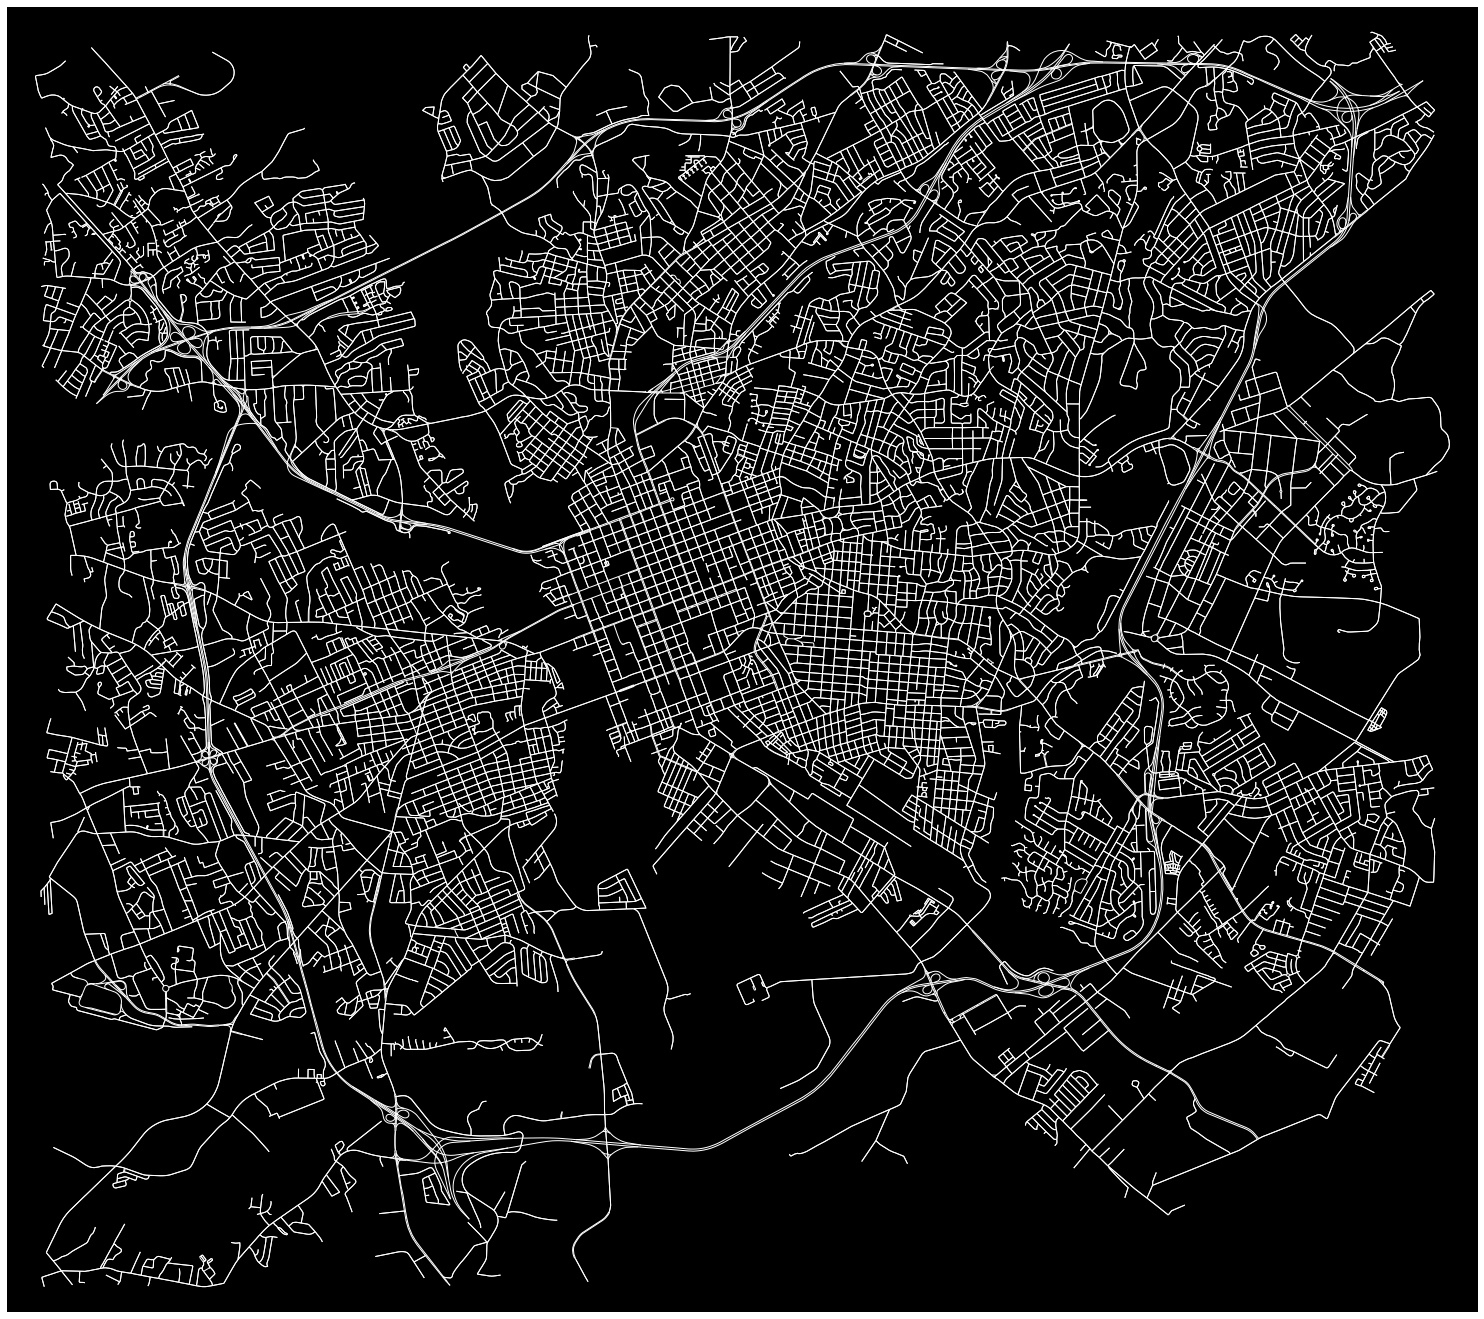

In [65]:
plt.ioff()
# get a graph for a city

# Set boundaries
north, west = 34.077988, -81.134183
south, east = 33.909673, -80.908490
city_name = 'Columbia'
cent_dir = './centrality_measures/' + city_name + '/'

#rf = '["highway"~"motorway|motorway_link|primary|primary_link|secondary|secondary_link|tertiary|tertiary_link"]'

# load entire graph
G = ox.graph_from_bbox(north, south, east, west, network_type='drive')


# Plot a map
fig, ax = ox.plot_graph(G, figsize=(40, 24), node_color='deepskyblue',
                        node_size=0, edge_linewidth=1,edge_color='white', show=False, close=False, bgcolor='black')

plt.show()
plt.close('all')

residential                    22888
tertiary                        1951
secondary                       1886
primary                         1499
unclassified                     708
motorway_link                    361
motorway                         164
trunk                            104
primary_link                      59
secondary_link                    47
tertiary_link                     44
trunk_link                        27
[unclassified, residential]       18
[tertiary, residential]           16
[tertiary, motorway_link]          2
[secondary, residential]           2
[tertiary, secondary]              2
[trunk, secondary]                 1
[primary, tertiary]                1
[tertiary, primary]                1
Name: highway, dtype: int64


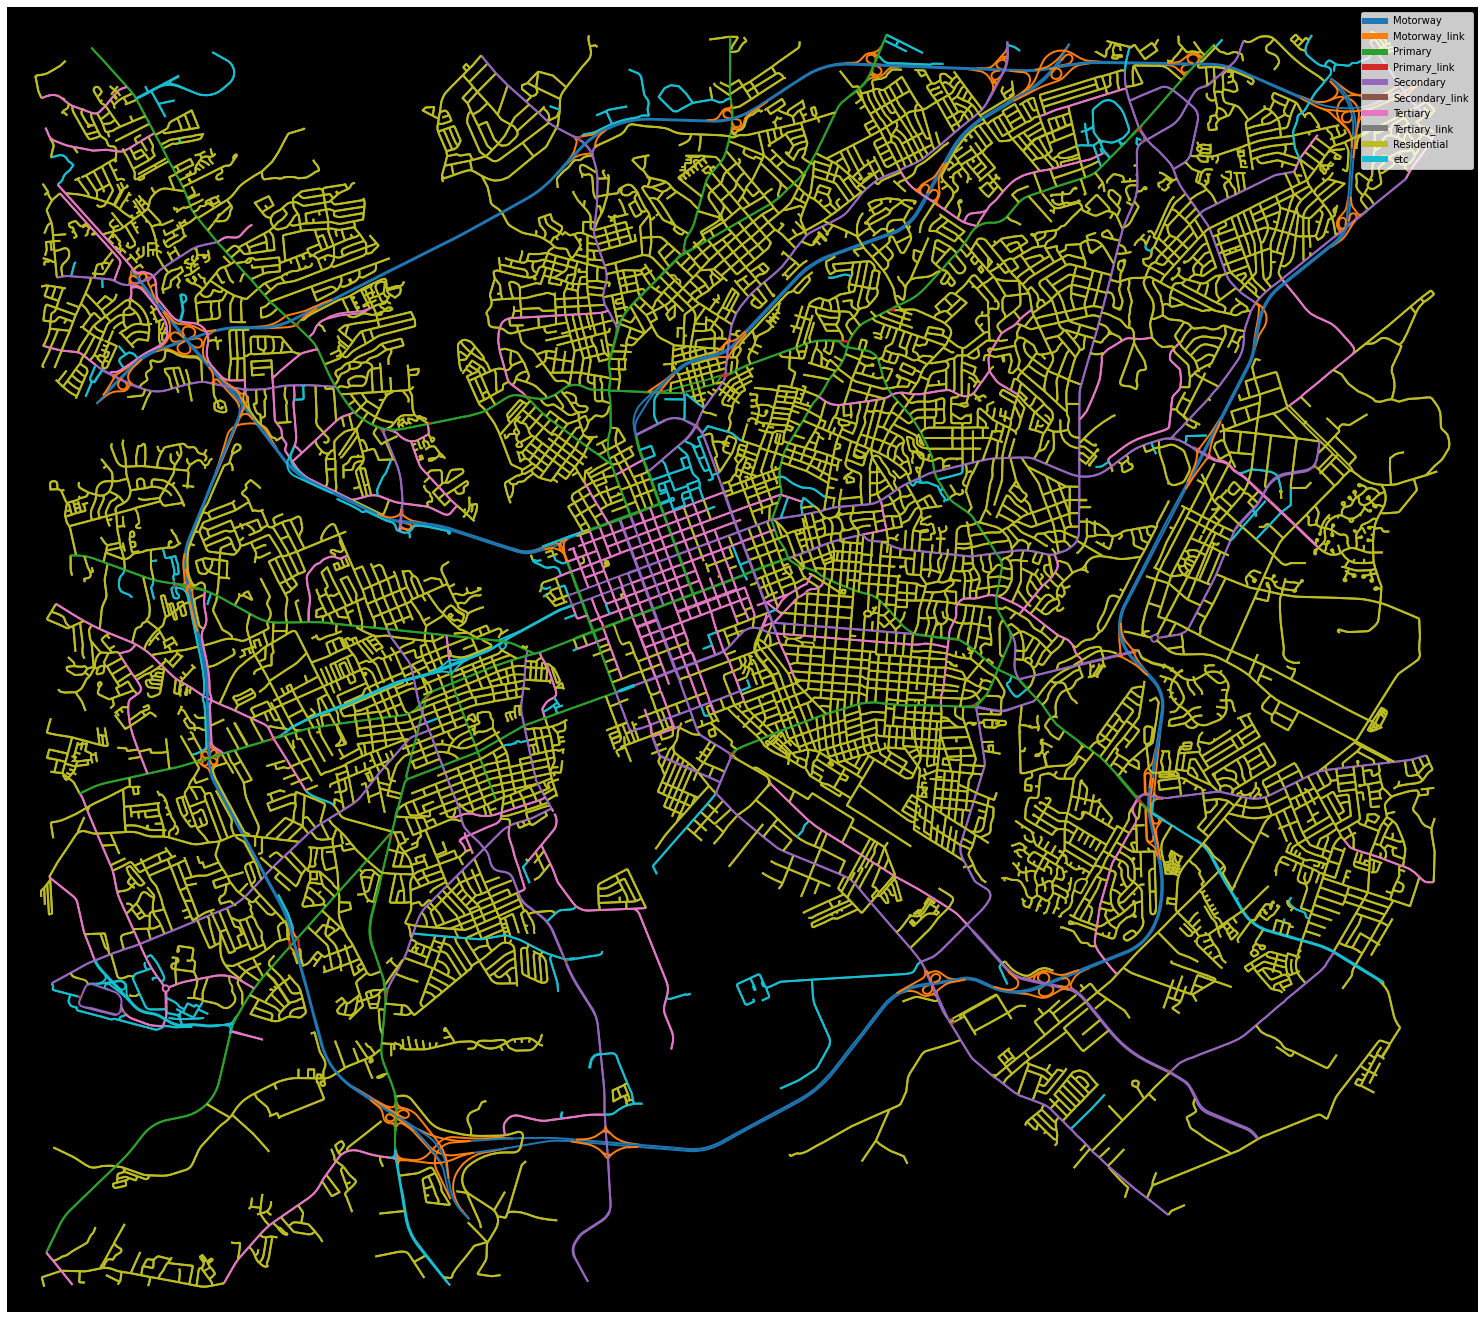

In [37]:
# Plot edge types on the map
edge_type_dic = {}
for (u,v,k) in G.edges:
    if G.edges[u,v,k]['highway'] == 'motorway':
        edge_type_dic[(u,v,k)] = 0
    elif G.edges[u,v,k]['highway'] == 'motorway_link':
        edge_type_dic[(u,v,k)] = 1
    elif G.edges[u,v,k]['highway'] == 'primary':
        edge_type_dic[(u,v,k)] = 2
    elif G.edges[u,v,k]['highway'] == 'primary_link':
        edge_type_dic[(u,v,k)] = 3
    elif G.edges[u,v,k]['highway'] == 'secondary':
        edge_type_dic[(u,v,k)] = 4
    elif G.edges[u,v,k]['highway'] == 'secondary_link':
        edge_type_dic[(u,v,k)] = 5
    elif G.edges[u,v,k]['highway'] == 'tertiary':
        edge_type_dic[(u,v,k)] = 6
    elif G.edges[u,v,k]['highway'] == 'tertiary_link':
        edge_type_dic[(u,v,k)] = 7
    elif G.edges[u,v,k]['highway'] == 'residential':
        edge_type_dic[(u,v,k)] = 8
    else:  # unclassified
        edge_type_dic[(u,v,k)] = 9
        
        
# Add edge type as a numerical value to edge attribute
nx.set_edge_attributes(G, edge_type_dic, "edge_type")

# Plot a map that represents the type of each edge
ec = ox.plot.get_edge_colors_by_attr(G, "edge_type", cmap='tab10', num_bins=10, start=0, stop=1, na_color='none')
edge_type_fig, edge_type_ax = ox.plot_graph(G, figsize=(40, 24), node_color='white', node_size=0,
                                          edge_linewidth=2, edge_color=ec, show=False, close=False, bgcolor='black')

#edge_type_fig.suptitle(t='Edge types', y=0.93, size=20)
   
# Add legend
cmap = plt.cm.get_cmap('tab10')

line_motor, = plt.plot([0, 0, 0], label='Motorway', c=cmap(0), linewidth = 6)
line_motor_link, = plt.plot([0, 0, 0], label='Motorway_link', c=cmap(1), linewidth = 6)
line_primary, = plt.plot([0, 0, 0], label='Primary', c=cmap(2), linewidth = 6)
line_primary_link, = plt.plot([0, 0, 0], label='Primary_link', c=cmap(3), linewidth = 6)
line_secondary, = plt.plot([0, 0, 0], label='Secondary', c=cmap(4), linewidth = 6)
line_secondary_link, = plt.plot([0, 0, 0], label='Secondary_link', c=cmap(5), linewidth = 6)
line_tertiary, = plt.plot([0, 0, 0], label='Tertiary', c=cmap(6), linewidth = 6)
line_tertiary_link, = plt.plot([0, 0, 0], label='Tertiary_link', c=cmap(7), linewidth = 6)
line_res, = plt.plot([0, 0, 0], label='Residential', c=cmap(8), linewidth = 6)
line_unclass, = plt.plot([0, 0, 0], label='Unclassified', c=cmap(9), linewidth = 6)


plt.legend([line_motor, line_motor_link,
            line_primary, line_primary_link,
            line_secondary, line_secondary_link,
            line_tertiary, line_tertiary_link,
            line_res, line_unclass],
           ['Motorway', 'Motorway_link',
            'Primary', 'Primary_link',
            'Secondary', 'Secondary_link',
            'Tertiary', 'Tertiary_link',
            'Residential', 'etc'], prop={'size': 10})

print(ox.graph_to_gdfs(G, nodes=False)['highway'].value_counts())
plt.show()
plt.close('all')

Number of nodes: 3433
Number of edges: 6851


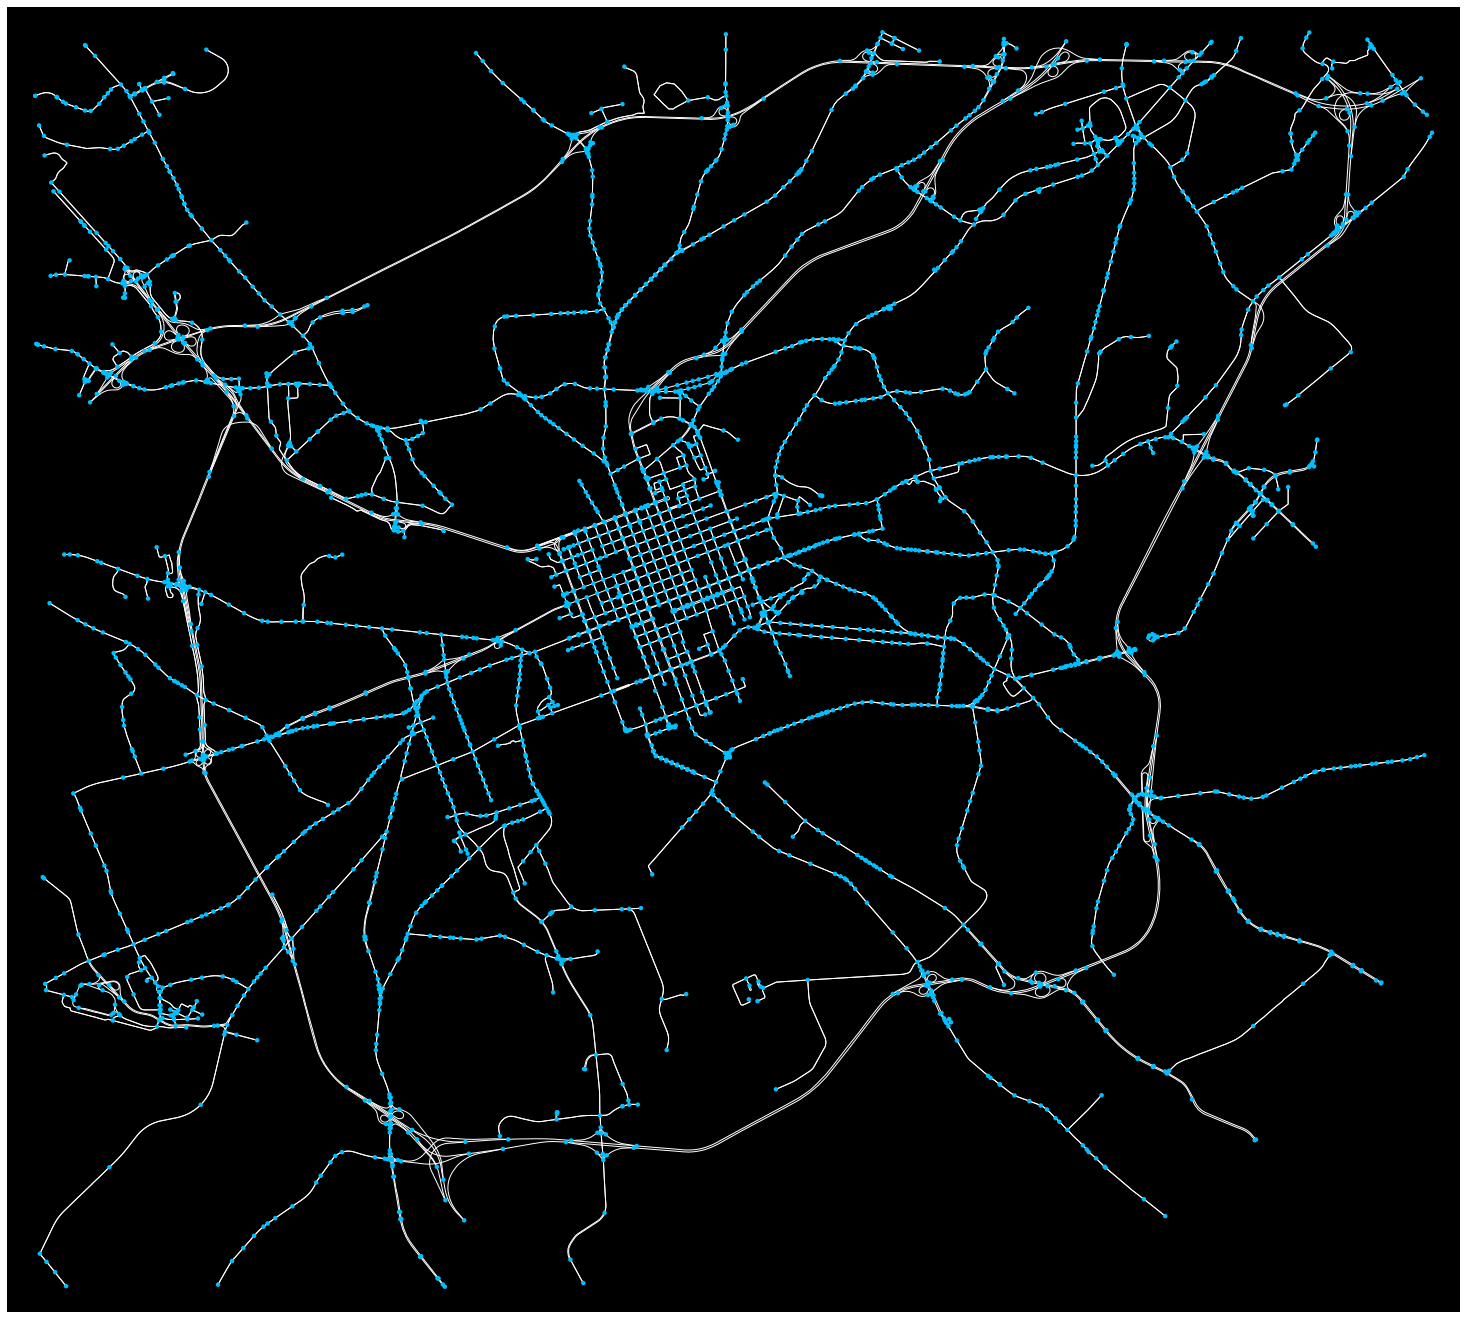

In [67]:
# load entire graph
G_wo_res = G.copy()

res_roads = []

for edge in G_wo_res.edges(keys=True, data=True):
    u,v,k,d = edge
    if d['highway'] == 'residential':
        res_roads.append((u, v, k))

G_wo_res.remove_edges_from(res_roads)

isolated_nodes = list(nx.isolates(G_wo_res))
G_wo_res.remove_nodes_from(isolated_nodes)


## remove islands ##
# check if the removal resulted in disconnected islands
undir_G = nx.Graph(G_wo_res)
nodeset_for_subgraphs = list(nx.connected_components(undir_G))
num_subgraphs = len(nodeset_for_subgraphs)

# if there are islands, sum the 'aggr_node_num' value in the nodes in each island and  
# distribute the summed value to the adjacent nodes remaining in the main road network
if num_subgraphs > 1:
    nodeset_for_largest_subgraph = max(nodeset_for_subgraphs) # the main network
    for nodeset in nodeset_for_subgraphs:
        if nodeset != nodeset_for_largest_subgraph: # if this subgraph is an island
            G_wo_res.remove_nodes_from(nodeset)

# print graph stats
print("Number of nodes:", G_wo_res.number_of_nodes())
print("Number of edges:", G_wo_res.number_of_edges())
            
# Plot a map
fig, ax = ox.plot_graph(G_wo_res, figsize=(40, 24), node_color='deepskyblue',
                        node_size=20, edge_linewidth=1,edge_color='white', show=False, close=False, bgcolor='black')

plt.show()
plt.close('all')

In [29]:
# Show the basic statistics of the map
ox.basic_stats(G_wo_res)

{'n': 3465,
 'm': 6893,
 'k_avg': 3.9786435786435788,
 'edge_length_total': 1225851.9039999926,
 'edge_length_avg': 177.8401137385743,
 'streets_per_node_avg': 3.2484848484848485,
 'streets_per_node_counts': {0: 0,
  1: 99,
  2: 17,
  3: 2339,
  4: 952,
  5: 51,
  6: 6,
  7: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.02857142857142857,
  2: 0.004906204906204906,
  3: 0.675036075036075,
  4: 0.27474747474747474,
  5: 0.01471861471861472,
  6: 0.0017316017316017316,
  7: 0.0002886002886002886},
 'intersection_count': 3366,
 'street_length_total': 820467.7439999976,
 'street_segment_count': 4365,
 'street_length_avg': 187.9651189003431,
 'circuity_avg': 1.0444545044065516,
 'self_loop_proportion': 0.0009163802978235968}

In [191]:
road_priority = {
    'motorway': 0,
    'primary': 1,
    'secondary': 2,
    'tertiary': 3,
    'residential': 4,
    'motorway_link': 5,
    'primary_link': 6,
    'secondary_link': 7,
    'tertiary_link': 8,
    'unclassified': 9
}

for edge in G.edges:

    edge_type = G.edges[edge]['highway']

    if type(edge_type) is list:
        sorted_type = sorted(edge_type, reverse=False, key = lambda d: road_priority[d])
        edge_type = sorted_type[0]
        G.edges[edge]['highway'] = edge_type

In [3]:
# Show the basic statistics of the map
ox.basic_stats(G)

{'n': 2110,
 'm': 4968,
 'k_avg': 4.709004739336493,
 'edge_length_total': 679845.2789999997,
 'edge_length_avg': 136.84486292270526,
 'streets_per_node_avg': 2.700947867298578,
 'streets_per_node_counts': {0: 0,
  1: 509,
  2: 21,
  3: 1188,
  4: 379,
  5: 10,
  6: 3},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.24123222748815165,
  2: 0.00995260663507109,
  3: 0.5630331753554503,
  4: 0.17962085308056872,
  5: 0.004739336492890996,
  6: 0.0014218009478672985},
 'intersection_count': 1601,
 'street_length_total': 395221.1800000007,
 'street_segment_count': 2855,
 'street_length_avg': 138.43123642732073,
 'circuity_avg': 1.0914162401183574,
 'self_loop_proportion': 0.005253940455341506}

In [4]:
def simplify(input_G):
    # define edge segment attributes to sum upon edge simplification
    attrs_to_sum = {"length", "travel_time"}
    
    # keep track of removed edges
    removed_edges = []
    removed_nodes = []
    
    acc_multi_edges = []
    acc_selfloops = []
    acc_dead_ends = []

    # make a copy to not mutate original graph object caller passed in
    G = input_G.copy()
     
    not_converged = True
    
    node_num = G.number_of_nodes()
    edge_num = G.number_of_edges()
    G_stat = (node_num, edge_num)
    
    cnt = 0
    
    print('Initial stat (nodes, edges):', G_stat)
    
    nx.set_node_attributes(G, float(1), 'aggr_node_num')
           
    while not_converged:
        
        # keep track of removed edges in this iteration
        removed_edges_per_iteration = []
        
        ## Remove multi-edges ##
        multi_edges = []
        multi_edge_removed_pair = set()
        
        for u,v,k,d in G.edges(data=True, keys=True):
            if (u,v) not in multi_edge_removed_pair:
                all_edges_btwn_nodes = list(G.get_edge_data(u,v).items())
                edge_dat_sorted_by_length = sorted(all_edges_btwn_nodes, reverse=False, key= lambda d: d[1]['length'])
                shortest_edge_key = edge_dat_sorted_by_length[0][0]
                multi_edge_removed_pair.add((u,v))
                
                for key, data in G.get_edge_data(u,v).items():
                    if key != shortest_edge_key:
                        multi_edges.append((u, v, key))
        
        # Record which edge chunks are going to be removed at this iteration
        for edge in multi_edges:
            if 'consolidated_edges' in G.edges[edge]:
                cons_edges = G.edges[edge]['consolidated_edges']
                removed_edges_per_iteration = removed_edges_per_iteration + cons_edges
                ### test purpose
                acc_multi_edges = acc_multi_edges + cons_edges
            else:
                removed_edges_per_iteration.append(edge)
                ### test purpose
                acc_multi_edges.append(edge)
                    
        # remove all the edges whose key is not 0
        G.remove_edges_from(multi_edges)

        ## Remove selfloops ##
        selfloops = list(nx.selfloop_edges(G, keys=True))
        
        for edge in selfloops:               
            if 'consolidated_edges' in G.edges[edge]:
                cons_edges = G.edges[edge]['consolidated_edges']
                removed_edges_per_iteration = removed_edges_per_iteration + cons_edges
                ### test purpose
                acc_selfloops = acc_selfloops + cons_edges
            else:
                removed_edges_per_iteration.append(edge)
                ### test purpose
                acc_selfloops.append(edge)

        G.remove_edges_from(selfloops)
        
    
        ## Remove dead-ends ##
        for _ in range(0,20):
            dead_ends = []
            
            st_cnt = ox.utils_graph.count_streets_per_node(G, nodes=None)
            nx.set_node_attributes(G, st_cnt, 'street_count')

            rm = []

            for node in G.nodes:
                if G.nodes[node]['street_count'] == 1:
                    rm.append(node)
                    dead_ends = dead_ends + list(G.in_edges(node, keys=True)) + list(G.out_edges(node, keys=True))
                    
            dead_ends = list(set(dead_ends))
            
            for edge in dead_ends:
                if 'consolidated_edges' in G.edges[edge]:
                    cons_edges = G.edges[edge]['consolidated_edges']
                    removed_edges_per_iteration = removed_edges_per_iteration + cons_edges
                    ### test purpose
                    acc_dead_ends = acc_dead_ends + cons_edges
                else:
                    removed_edges_per_iteration.append(edge)
                    ### test purpose
                    acc_dead_ends.append(edge)
            
            # Add the number of aggregated nodes to its the only neighbor
            for node in rm:
                aggr_node_num = G.nodes[node]['aggr_node_num']
                
                suc = list(G.successors(node))  #  edge from node to neighbors 
                pre_suc = list(G.predecessors(node))  #  edge from neighbors to node
                
                if len(suc) != 0:
                    neighbor_node = suc[0]
                else:
                    neighbor_node = pre_suc[0]
                                
                G.nodes[neighbor_node]['aggr_node_num'] += aggr_node_num
            
            G.remove_nodes_from(rm)
            removed_nodes += rm
            
            
        ## Remove gridiron nodes ##
        gridiron_nodes = []
        gridiron_cand = []
        nx.set_node_attributes(G, False, 'gridiron_cand')
        incident_edges = []
        disconnected_gridiron_nodes = []
        max_len = 300
        
        for node in G.nodes:
            deg = G.degree[node]
            num_neighbors = len(list(G.neighbors(node)))
            if num_neighbors == 4:
                incidents = list(G.out_edges(node, keys=True)) + list(G.in_edges(node, keys=True))
                residential = True
                isCand = False
                
                incident_length = []
                for edge in incidents:
                    road_type = G.edges[edge]['highway']
                    edge_length = G.edges[edge]['length']
                    incident_length.append(edge_length)
                    
                    if road_type != 'residential':
                        residential = False
                        
                if max_len > max(incident_length):
                    isCand = True

                if residential and isCand:
                    G.nodes[node]["gridiron_cand"] = True
                    gridiron_cand.append(node)
        
        for node in gridiron_cand:
            incidents = list(G.out_edges(node, keys=True)) + list(G.in_edges(node, keys=True))
            isGrid = False
            for adj_node in G.neighbors(node):
                if G.nodes[adj_node]['gridiron_cand']:
                    isGrid = True
            if isGrid:
                gridiron_nodes.append(node)
                incident_edges += incidents
                
        incident_edges = list(set(incident_edges))
        for edge in incident_edges:
            if 'consolidated_edges' in G.edges[edge]:
                cons_edges = G.edges[edge]['consolidated_edges']
                removed_edges_per_iteration = removed_edges_per_iteration + cons_edges
            else:
                removed_edges_per_iteration.append(edge)
        
        for node in gridiron_nodes:
            # skip this iteration if the node is already removed
            if node in disconnected_gridiron_nodes: continue
            
            # track regional node density
            adjacent_nodes = set(G.neighbors(node))
            if node in adjacent_nodes:
                adjacent_nodes.remove(node)
            adj_node_num = len(adjacent_nodes)
            aggr_val =  G.nodes[node]['aggr_node_num']
            
            
            for adj_node in adjacent_nodes:
                G.nodes[adj_node]['aggr_node_num'] += (aggr_val / adj_node_num)
            
            # remove a gridiron node
            removed_nodes.append(node)
            G.remove_node(node)
            
            # check if the removal resulted in disconnected islands
            undir_G = nx.Graph(G)
            nodeset_for_subgraphs = list(nx.connected_components(undir_G))
            num_subgraphs = len(nodeset_for_subgraphs)
            
            # if there are islands, sum the 'aggr_node_num' value in the nodes in each island and  
            # distribute the summed value to the adjacent nodes remaining in the main road network
            if num_subgraphs > 1:
                nodeset_for_largest_subgraph = max(nodeset_for_subgraphs)
                adjacent_nodes_in_largest_subgraph = []
                
                for adj_node in adjacent_nodes:
                    if adj_node in nodeset_for_largest_subgraph:
                        adjacent_nodes_in_largest_subgraph.append(adj_node)
                        
                adj_node_num_in_largest_subgraph = len(adjacent_nodes_in_largest_subgraph)
                
                for nodeset in nodeset_for_subgraphs:
                    if nodeset != nodeset_for_largest_subgraph: # if this subgraph is an island
                        removed_nodes += nodeset
                        aggr_sum = 0
                        for node_in_subgraph in nodeset:
                            aggr_sum += G.nodes[node_in_subgraph]['aggr_node_num']
                        
                        for adj_node in adjacent_nodes_in_largest_subgraph:
                            G.nodes[adj_node]['aggr_node_num'] += (aggr_sum / adj_node_num_in_largest_subgraph)
                        
                        edges_in_subgraph = []
                        for removing_node in nodeset:
                            if removing_node in gridiron_nodes:
                                disconnected_gridiron_nodes.append(removing_node)
                                
                            removing_node_incidents = list(G.out_edges(removing_node, keys=True)) + list(G.in_edges(removing_node, keys=True))
                            edges_in_subgraph += removing_node_incidents
                            
                        edges_in_subgraph = list(set(edges_in_subgraph))

                        for edge in edges_in_subgraph:
                            if 'consolidated_edges' in G.edges[edge]:
                                cons_edges = G.edges[edge]['consolidated_edges']
                                removed_edges_per_iteration = removed_edges_per_iteration + cons_edges
                            else:
                                removed_edges_per_iteration.append(edge)
                            
                        G.remove_nodes_from(nodeset)
                                
        ## Remove interstitial nodes ##
        all_nodes_to_remove = []
        all_edges_to_add = []
        processed_path = []
        
        # generate each path that needs to be simplified
        for path in ox.simplification._get_paths_to_simplify(G, strict=True):            
            # add the interstitial edges we're removing to a list so we can retain
            # their spatial geometry
            path_attributes = dict()
            edges_in_path = []
            
            path_aggr_node_num = 0
            org_node = path[0]
            dst_node = path[-1]
            
            for node in path[1:-1]: # interstitial nodes
                node_aggr_node_num = G.nodes[node]['aggr_node_num']
                path_aggr_node_num += node_aggr_node_num
            
            end_points = {org_node, dst_node}
            interstitial_nodes = set(path[1:-1])
            
            if org_node == dst_node: # i.e. self-loop (set "end_points" above has only one element)
                path_aggr_node_num = 2 * path_aggr_node_num
                
            nodes_on_path = (end_points, interstitial_nodes)
            
            # there may be reverse path that goes through the same nodes
            # avoid path_aggr_node_num being summed twice
            if nodes_on_path not in processed_path:
                processed_path.append(nodes_on_path)
                for node in end_points:
                    G.nodes[node]['aggr_node_num'] += (path_aggr_node_num / 2)
                                
            for u, v in zip(path[:-1], path[1:]):
                
                # get edge between these nodes. Multi-edges do not exist since already removed
                edge_key_and_data = tuple(G.get_edge_data(u, v).items())[0]
                edge_key = edge_key_and_data[0]
                exact_edge = (u,v, edge_key)
                edge_data = edge_key_and_data[1]
                edges_in_path.append(exact_edge)
                
                for attr in edge_data:
                    if attr in path_attributes:
                        # if this key already exists in the dict, append it to the
                        # value list
                        dat_val = edge_data[attr]
                        if type(dat_val) == list:
                            path_attributes[attr] = path_attributes[attr] + edge_data[attr]
                        else:
                            path_attributes[attr].append(edge_data[attr])
                    else:
                        # if this key doesn't already exist, set the value to a list
                        # containing the one value
                        dat_val = edge_data[attr]
                        if type(dat_val) == list:
                            path_attributes[attr] = edge_data[attr]
                        else:
                            path_attributes[attr] = [edge_data[attr]]
                
            # consolidate the path's edge segments' attribute values
            for attr in path_attributes:
                if attr in attrs_to_sum:
                    # if this attribute must be summed, sum it now
                    path_attributes[attr] = sum(path_attributes[attr])
                elif (attr != "geometry") and len(set(path_attributes[attr])) == 1:
                    # if there's only 1 unique value in this attribute list,
                    # consolidate it to the single value (the zero-th):
                    path_attributes[attr] = path_attributes[attr][0]
                elif attr != "geometry":
                    # otherwise, if there are multiple values, keep one of each
                    path_attributes[attr] = list(set(path_attributes[attr]))
            
            # Check consolidated edges are all in the 'consolidated_edges'
            if 'consolidated_edges' not in path_attributes:
                # none of the edges in path is previously consolidated
                # all the exact edges in the path is added to 'consolidated edges'
                path_attributes['consolidated_edges'] = edges_in_path
            else:
                # at least one of the edges in path is previously consolidated
                # previously not consolidated edges need to be added to 'consolidated edges'
                for edge in edges_in_path:
                    if edge in input_G.edges:
                        path_attributes['consolidated_edges'].append(edge)
                                               
            # construct the new consolidated edge's geometry for this path
            if 'geometry' not in path_attributes:
                path_attributes["geometry"] = LineString(
                    [Point((G.nodes[node]["x"], G.nodes[node]["y"])) for node in path]
                )
            else:
                points = []
                geometry = path_attributes['geometry']

                # Gather geometry dataframes in a list
                gm_df = []
                for gm in geometry:
                    x,y = gm.coords.xy
                    df = pd.DataFrame({'x':x,'y':y})
                    gm_df.append(df)

                for node in path:
                    node_x = G.nodes[node]['x']
                    node_y = G.nodes[node]['y']
                    node_coord = (node_x, node_y)
                    node_point = Point(node_coord)
                    #if node_point in points: continue

                    used_df_idx = [] # Prevent using duplicate geometry in reverse=order
                    node_belong_to_gm = False

                    for i, df in enumerate(gm_df):
                        # check if this node has geometry
                        has_gm = ((df['x'] == node_x) & (df['y'] == node_y))

                        # if geometry exists, add all the points in it
                        if has_gm.loc[has_gm.index[0]] and i not in used_df_idx:
                            node_belong_to_gm = True
                            used_df_idx.append(i)
                            for idx, row in df.iterrows():
                                x_coord = row['x']
                                y_coord = row['y']
                                geo_point = Point((x_coord, y_coord))
                                if geo_point not in points: points.append(geo_point)
                        elif has_gm.loc[has_gm.index[-1]] and i not in used_df_idx:
                            node_belong_to_gm = True
                            used_df_idx.append(i)
                            df = df[::-1]
                            for idx, row in df.iterrows():
                                x_coord = row['x']
                                y_coord = row['y']
                                geo_point = Point((x_coord, y_coord))
                                if geo_point not in points: points.append(geo_point)

                    # for node without geometry, simply add its single point
                    if not node_belong_to_gm:
                        points.append(node_point)

                path_attributes["geometry"] = LineString(points)

            # add the nodes and edge to their lists for processing at the end
            all_nodes_to_remove.extend(path[1:-1])
            all_edges_to_add.append(
                {"origin": path[0], "destination": path[-1], "attr_dict": path_attributes}
            )

        # for each edge to add in the list we assembled, create a new edge between
        # the origin and destination
        for edge in all_edges_to_add:
            G.add_edge(edge["origin"], edge["destination"], **edge["attr_dict"])
            
        # finally remove all the interstitial nodes between the new edges
        G.remove_nodes_from(set(all_nodes_to_remove))
        removed_nodes += list(set(all_nodes_to_remove))
        
        # check convergence
        current_node_num = G.number_of_nodes()
        current_edge_num = G.number_of_edges()
        current_stat = (current_node_num, current_edge_num)
        
        if G_stat == current_stat:
            not_converged = False
            break
        else:           
            G_stat = current_stat
            removed_edges.append(removed_edges_per_iteration)
            cnt += 1
        
        print('Stat at iteration', cnt, '(nodes, edges):', G_stat)
            
    print('Graph converged at iteration', cnt)
        
    return G, removed_edges, removed_nodes, (acc_multi_edges, acc_selfloops, acc_dead_ends)

Initial stat (nodes, edges): (11113, 29781)
Stat at iteration 1 (nodes, edges): (6238, 17418)
Stat at iteration 2 (nodes, edges): (5633, 15811)
Stat at iteration 3 (nodes, edges): (5510, 15436)
Stat at iteration 4 (nodes, edges): (5477, 15335)
Stat at iteration 5 (nodes, edges): (5465, 15300)
Stat at iteration 6 (nodes, edges): (5461, 15287)
Stat at iteration 7 (nodes, edges): (5457, 15275)
Graph converged at iteration 7


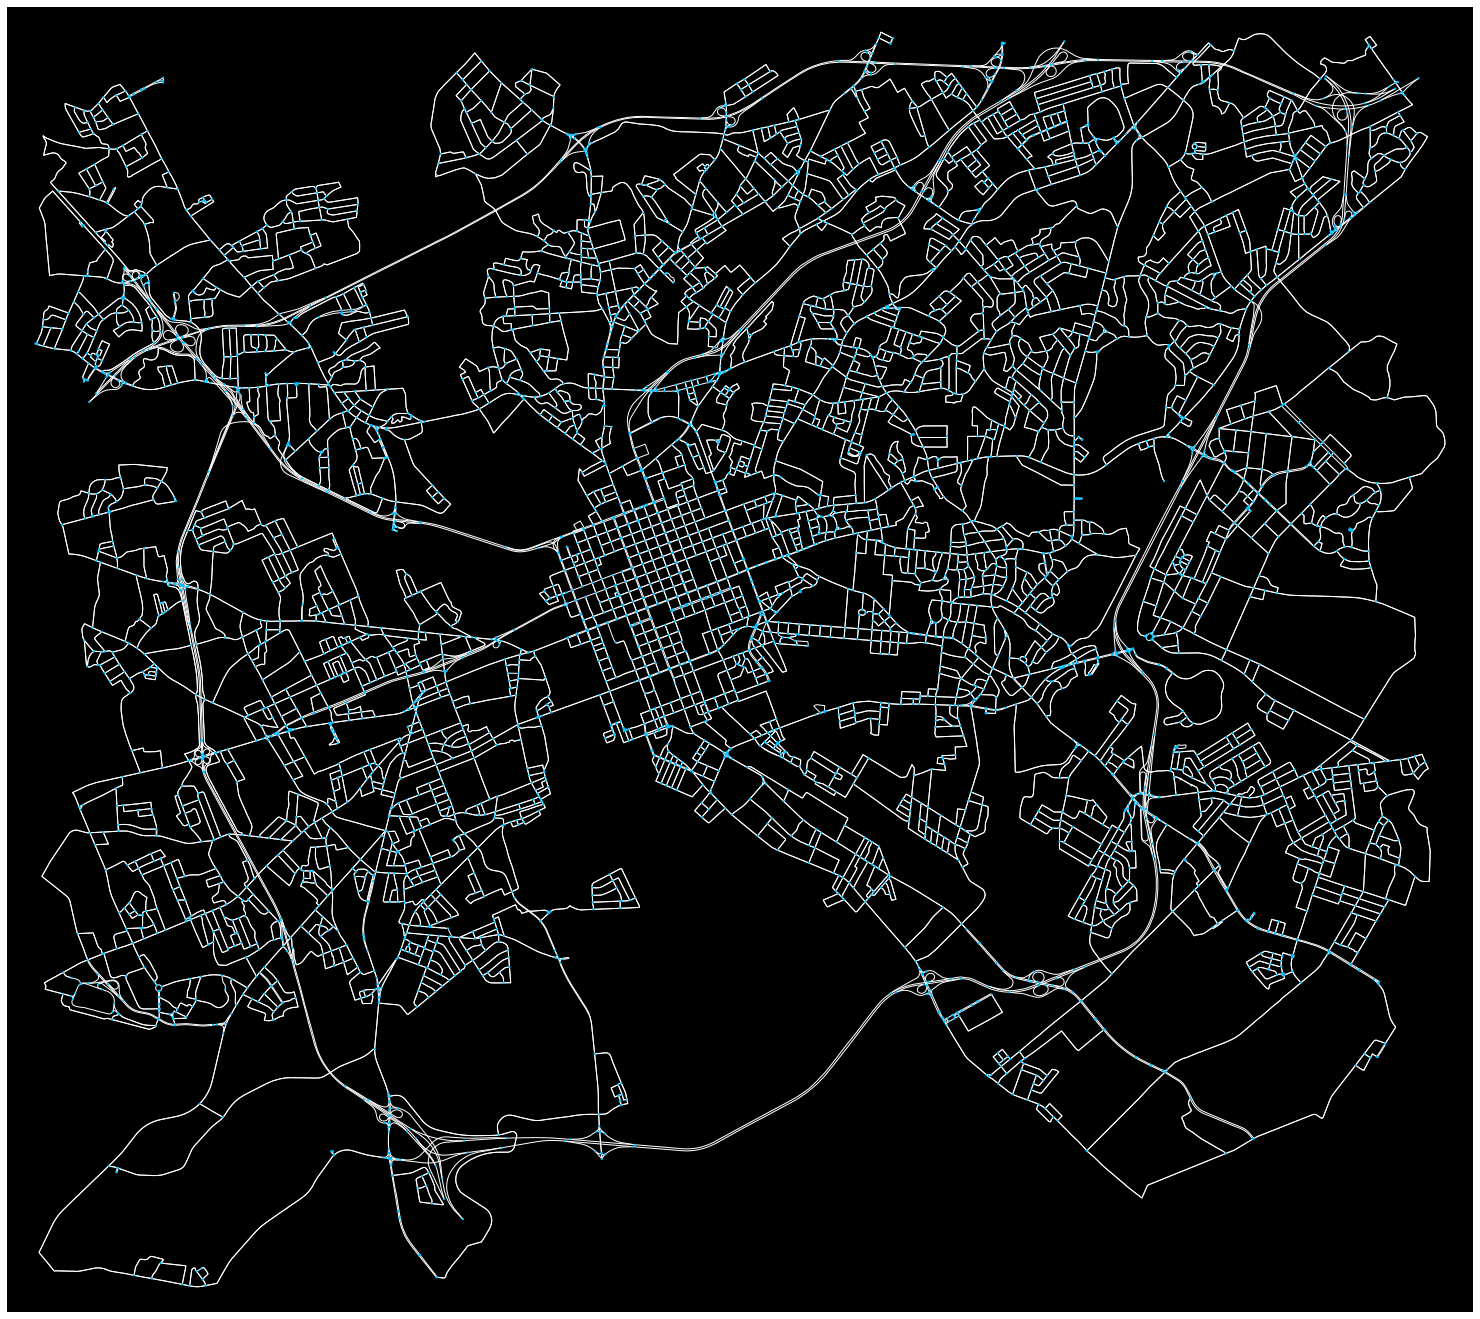

In [5]:
G1, removed_edges, removed_nodes, removed_cat = simplify(G)

# Plot a map
fig, ax = ox.plot_graph(G1, figsize=(40, 24), node_color='deepskyblue',
                        node_size=5, edge_linewidth=1,edge_color='white', show=False, close=False, bgcolor='black')

plt.show()
plt.close('all')

### Estimate $C^B$ of "original" network from "simplified" network
Standard $C^B$ of an edge $e$ is computed as follows:

$$ C^B(e) = \sum_{s,t \in V} \frac{\sigma(s,t|e)}{\sigma(s,t)}	 $$

Where $V$ is the set of nodes in a graph, $\sigma(s,t)$ is the number of shortest paths between an OD pair $(s,t)$, and $\sigma(s,t|e)$ is the number of those paths that passing through edge $e$. However, in simplified graph, many nodes are removed and the set of nodes $V'$ has much less nodes than the node set $V$ in the original graph, resulting in slightly different $C^B$ distribution. To estimate $C^B$ distribution of the original network using simplified network, we use the node attribute `aggr_node_num`.

In simplification process, `aggr_node_num` value moves from nodes being removed to their nearest nodes, which causes remaining nodes in largely simplified area have high value of `aggr_node_num`. It implies that `aggr_node_num` of a node intuitively represents that how many nodes are collapsed to the node. From the locality and the fact that removed components in the simplified graph do not provide path to other components, we can assume that all the shortest paths from the nodes collapsed into node $s$ to node $t$ pass through node $s$. This assumption allow us to estimate $C^B$ distribution of the original network using the simplified network and `aggr_node_num` attributes as follows:

$$ C^B_{est}(e) = \sum_{s,t \in V'} \frac{\sigma(s,t|e)}{\sigma(s,t)} \times aggr_s \times aggr_t	 $$

Where $V'$ is the set of nodes in the simplified graph, and aggr is the value of `aggr_node_num` of a node.

In [11]:
## Compute betweenness centrality weighted by 'length' and 'aggr_node_num'              
def accumulate_sigma(G, all_paths, bc_dic, multiple, weight='length'):
    path_num = len(all_paths)
    
    for path in all_paths:
        for u, v in zip(path[:-1], path[1:]):
            all_edges_btwn_nodes = list(G.get_edge_data(u,v).items())
            edge_dat_sorted_by_length = sorted(all_edges_btwn_nodes, reverse=False, key= lambda d: d[1][weight])
            shortest_edge_key = edge_dat_sorted_by_length[0][0]
            shortest_edge = (u, v, shortest_edge_key)

            bc_dic[shortest_edge] += multiple / path_num
        
def estimated_betweenness_centrality(G, weight='length', normalize='True'):
    
    nodes = G.nodes
    n = G.number_of_nodes()
    print('Compute betweenness centrality in the input graph with', n, 'nodes')
    
    total_start_time = time.time()
    
    betweenness_centrality = dict.fromkeys(G.edges, 0)    
    
    for idx, u in enumerate(nodes):
        print('Working node number:', idx+1)    
        start_time = time.time()
        aggr_on_u = G.nodes[u]['aggr_node_num']
        
        for v in nodes:
            aggr_on_v = G.nodes[v]['aggr_node_num']
            if u != v:
                try:
                    multiple = aggr_on_u * aggr_on_v
                    all_paths = list(nx.all_shortest_paths(G, u, v, weight=weight))
                    accumulate_sigma(G, all_paths, betweenness_centrality, multiple, weight=weight)
                except Exception:
                    pass # there node v may not be reachable from node u
                
        end_time = time.time()
        if idx == 0:
            elapsed_time = end_time - start_time
            print('Estimated time to finish:', elapsed_time * (n-1))
    
    if normalize:
        for edge in betweenness_centrality:
            denominator = n * (n-1)
            betweenness_centrality[edge] = betweenness_centrality[edge] / denominator                
            
    total_end_time = time.time()
    total_elapsed_time = total_end_time - total_start_time
    
    print('Elapsed time for the computation: ', total_elapsed_time)
    
    return betweenness_centrality

In [ ]:
bc = estimated_betweenness_centrality(G1, weight='length', normalize='True')

Compute betweenness centrality in the input graph with 5457 nodes
Working node number: 1
Estimated time to finish: 940623.672706604
Working node number: 2
Working node number: 3
Working node number: 4
Working node number: 5
Working node number: 6
Working node number: 7
Working node number: 8
Working node number: 9
Working node number: 10
Working node number: 11
Working node number: 12
Working node number: 13
Working node number: 14
Working node number: 15
Working node number: 16
Working node number: 17
Working node number: 18
Working node number: 19
Working node number: 20
Working node number: 21
Working node number: 22
Working node number: 23
Working node number: 24
Working node number: 25
Working node number: 26
Working node number: 27
Working node number: 28
Working node number: 29
Working node number: 30
Working node number: 31
Working node number: 32
Working node number: 33
Working node number: 34
Working node number: 35
Working node number: 36
Working node number: 37
Working node

In [ ]:
# create a binary pickle file 
f = open("bc_simplified_with_aggr_num.pkl","wb")
pickle.dump(bc,f)

# close file
f.close()

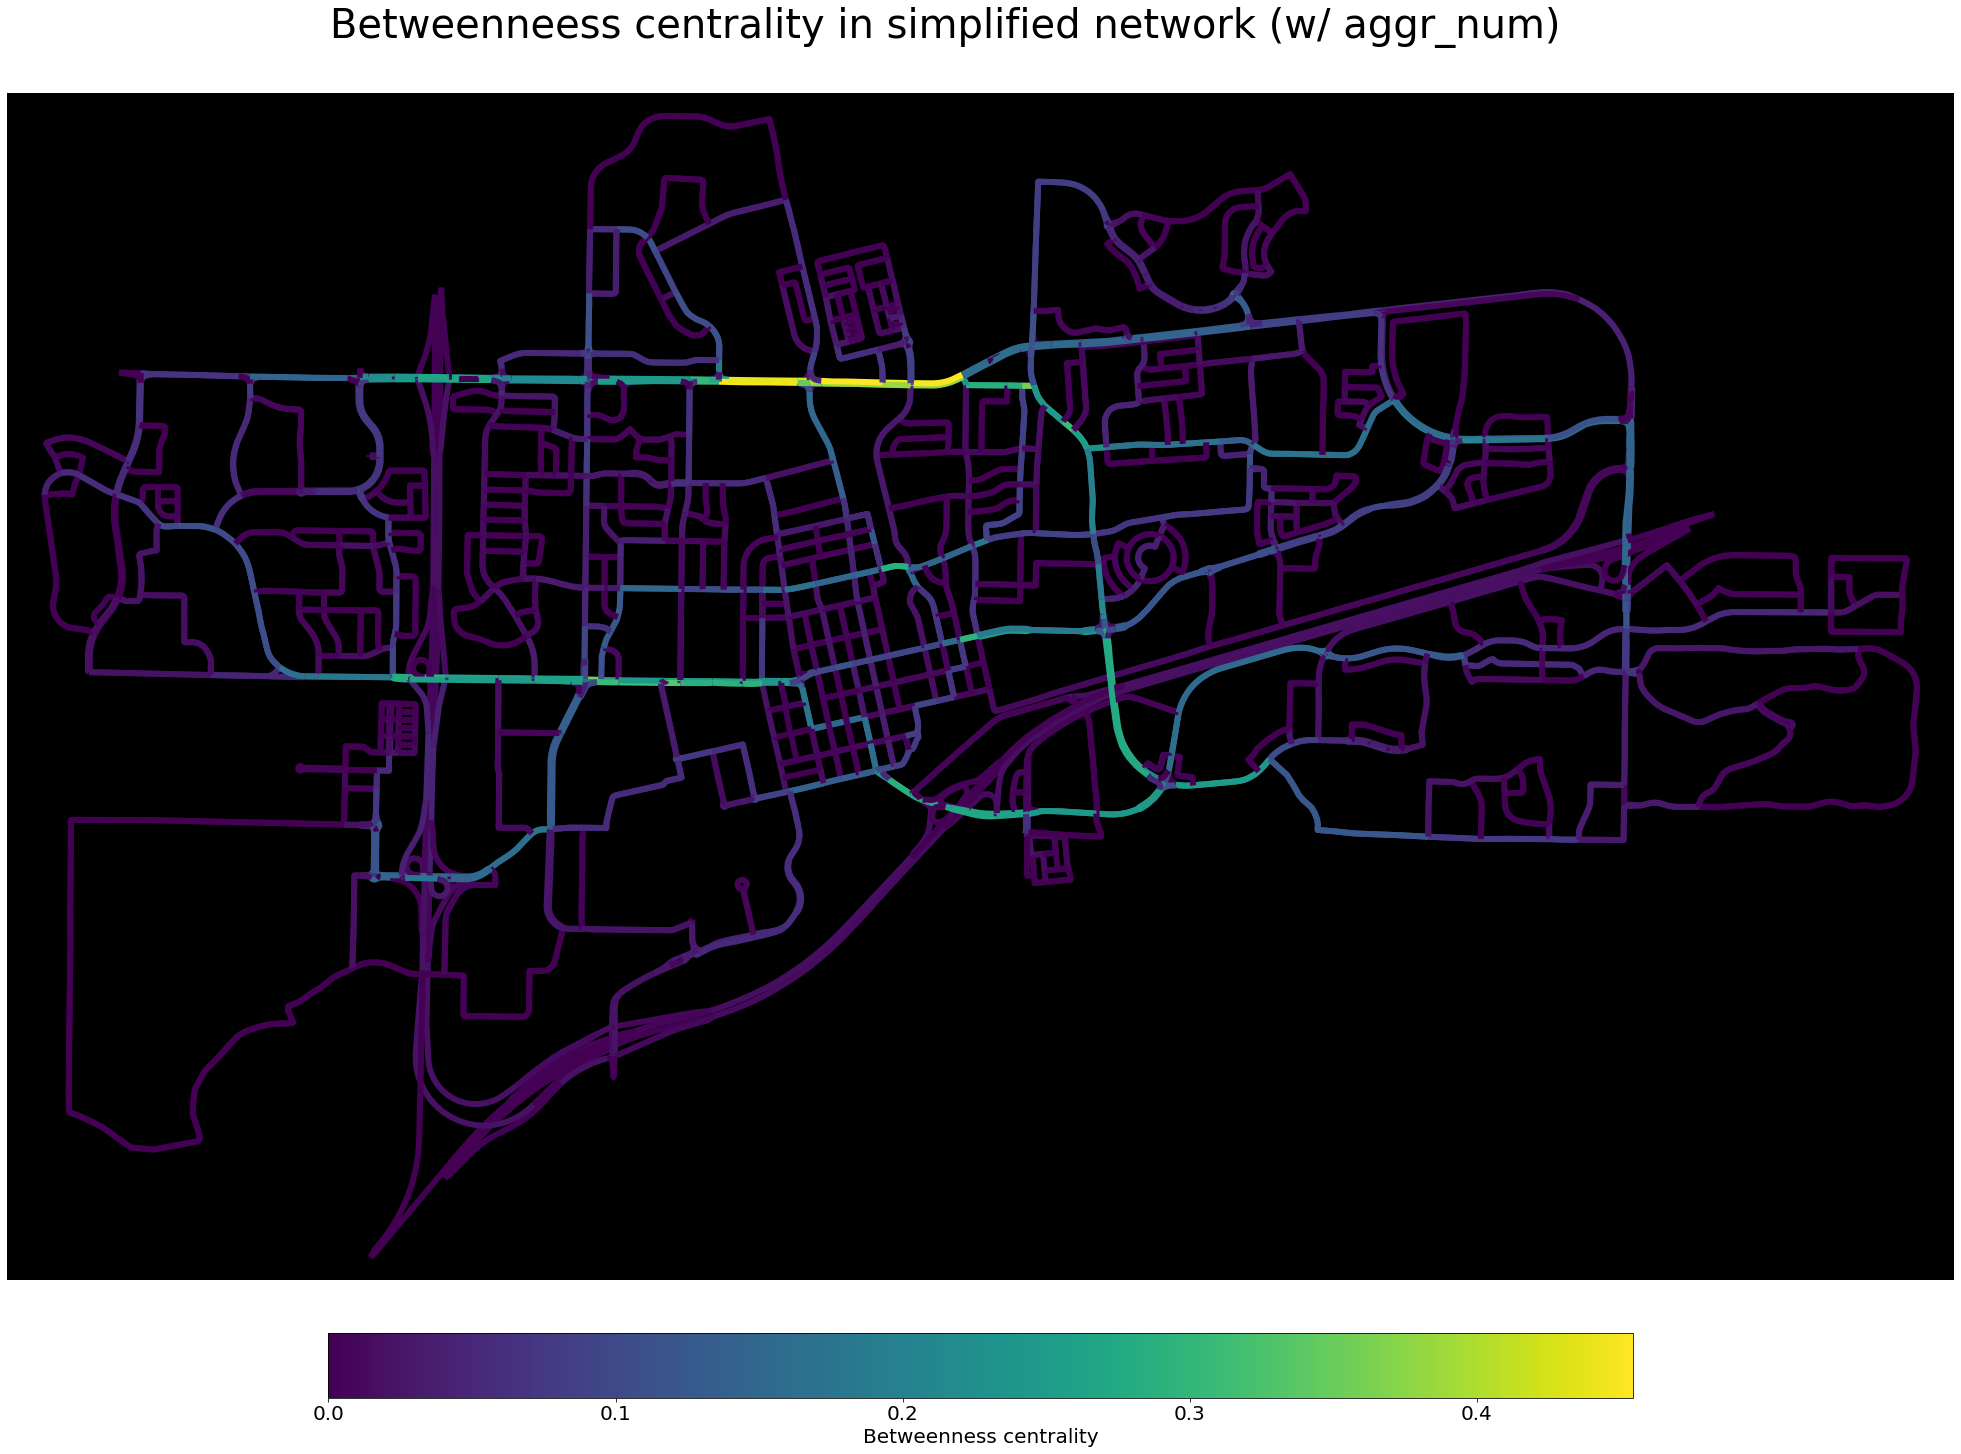

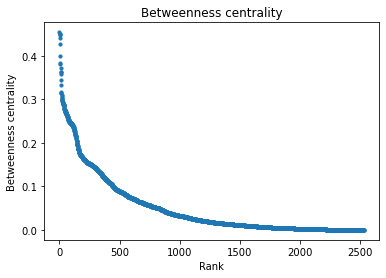

In [10]:
# load data from a binary pickle file 
fname = cent_dir + 'bc_simplified_with_aggr_num.pkl'
rf = open(fname,"rb")
bc = pickle.load(rf)
rf.close()

nx.set_edge_attributes(G1, bc, "betweenness_centrality")

bet_edge_col = ox.plot.get_edge_colors_by_attr(G1, "betweenness_centrality", cmap='viridis', start=0, stop=1, na_color='none')
bet_fig, bet_ax = ox.plot_graph(G1, figsize=(40,24), node_color='b', node_size=0,
                                edge_linewidth=6, edge_color=bet_edge_col, show=False, close=False, bgcolor='black')

# Add a legend
cmap = plt.cm.get_cmap('viridis')
norm = plt.Normalize(vmin=min(bc.values()), vmax=max(bc.values()))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cb = bet_fig.colorbar(sm, fraction=0.05, pad=0.04, orientation='horizontal')
cb.set_label('Betweenness centrality', fontsize = 20)
cb.ax.tick_params(labelsize=20)

bet_fig.suptitle(t='Betweenneess centrality in simplified network (w/ aggr_num)', y=0.93, size=40)
plt.show()
plt.close('all')

bc_vals = sorted(bc.values(), reverse=True)
x = [i for i in range(0, len(bc_vals))]

plt.scatter(x, bc_vals, s=10)
plt.title('Betweenness centrality')
plt.xlabel('Rank')
plt.ylabel('Betweenness centrality')

plt.show()
plt.close('all')

In [ ]:
# Get betweenness centrality of each edge
G2 = nx.DiGraph(G1)
bet_cent=nx.edge_betweenness_centrality(G2, weight='length')

# Add betweenness centrality to edge attribute
formatted_bet_cent = {}
for (u, v), value in bet_cent.items():
    keys = list(G1.get_edge_data(u,v).keys())
    if len(keys) != 1: raise ValueError('Simplified graph has multi-edge')
    key = keys[0]
    formatted_bet_cent[(u, v, key)] = value
    
#nx.set_edge_attributes(G1, 0, "betweenness_centrality")
nx.set_edge_attributes(G1, formatted_bet_cent, "betweenness_centrality")
bc = nx.get_edge_attributes(G1, 'betweenness_centrality')

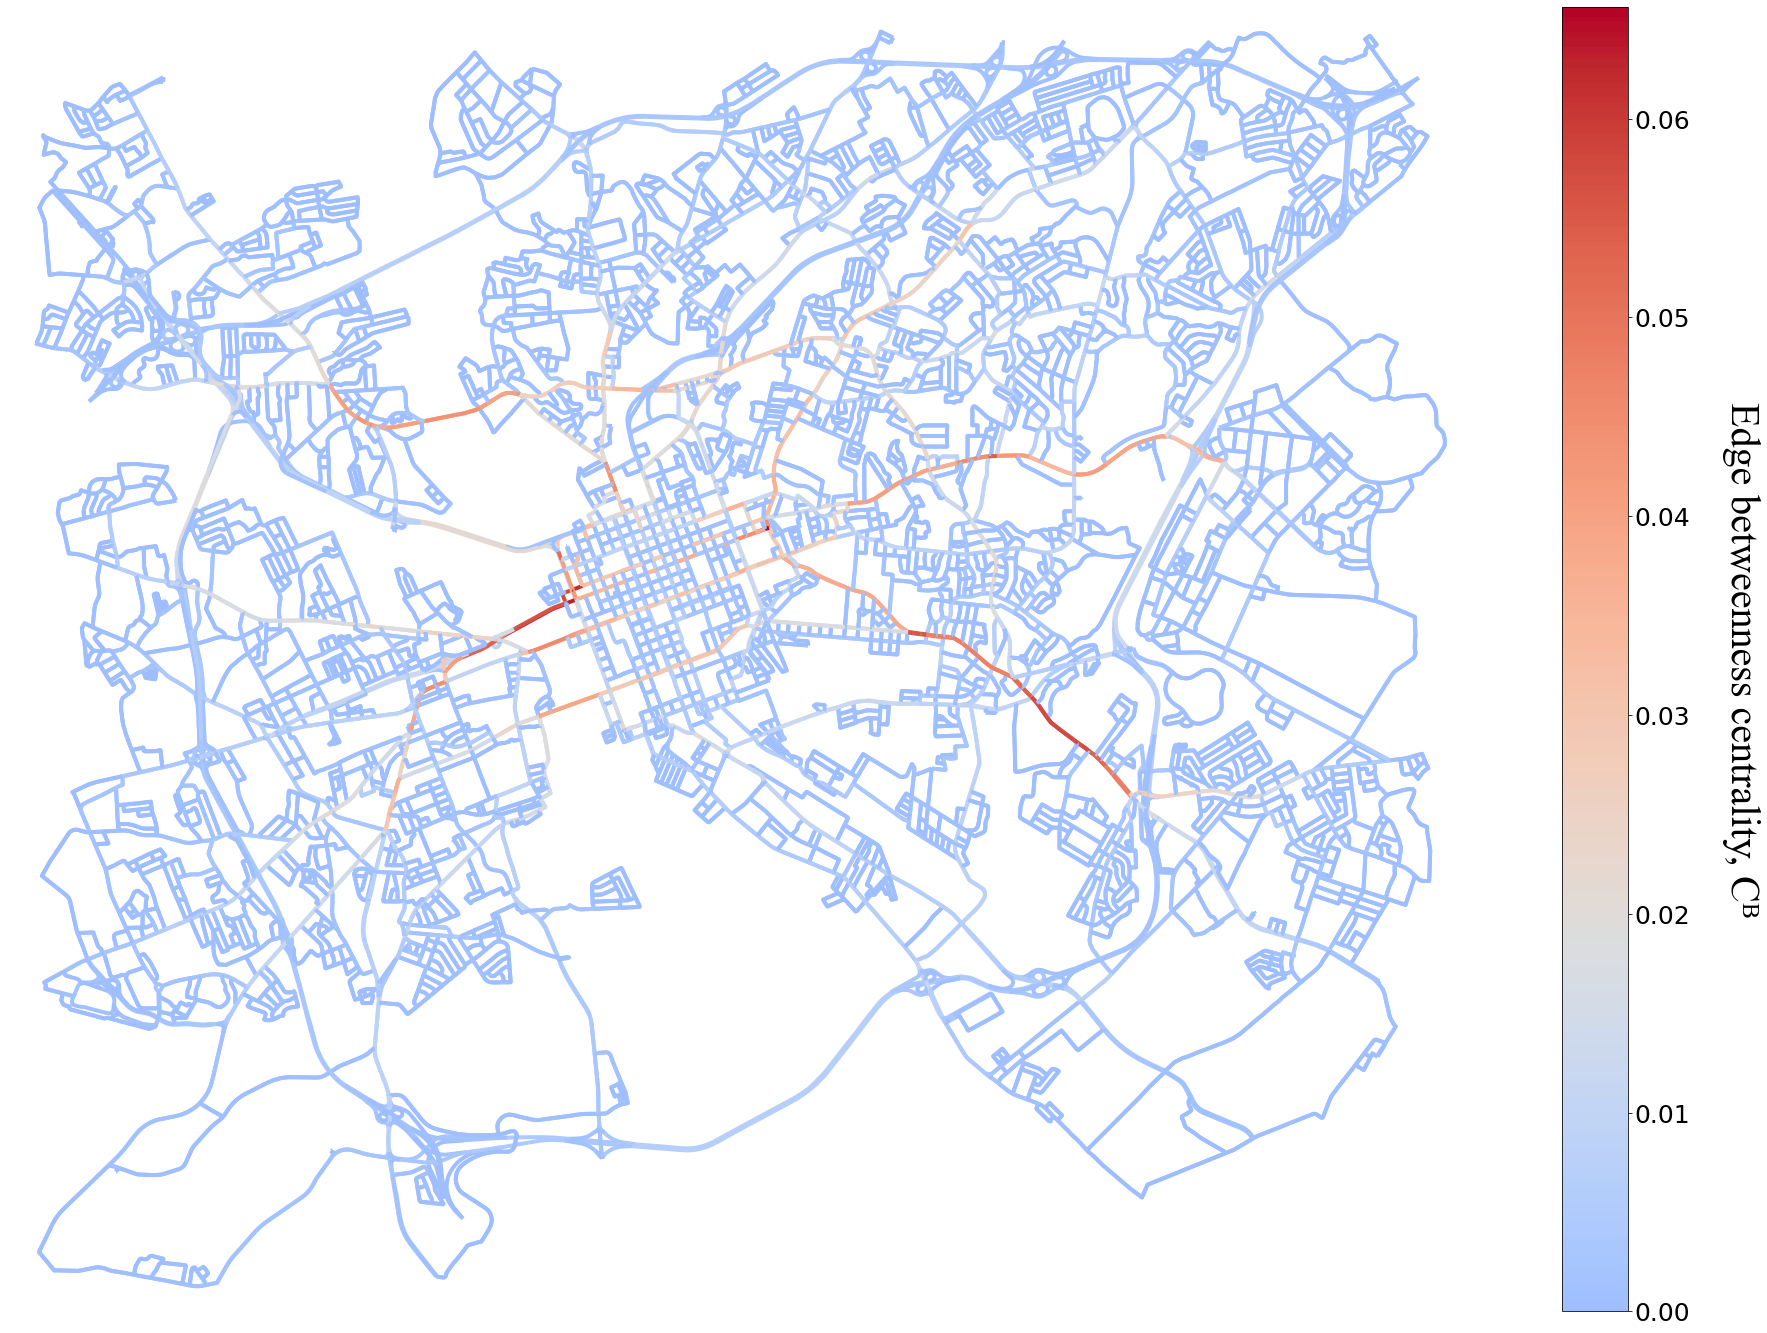

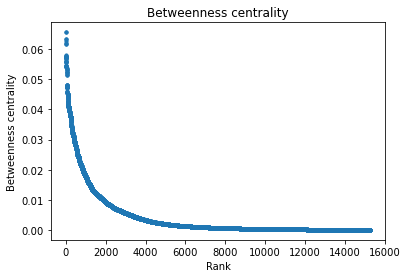

In [180]:
# load bc data from saved file
rf = open(cent_dir + "bc_simplified.pkl","rb")
bc = pickle.load(rf)
rf.close()

nx.set_edge_attributes(G1, bc, "betweenness_centrality")

cmap_name = 'coolwarm'
#col_bin = 10
min_col = 0.3
max_col = 1

bet_edge_col = ox.plot.get_edge_colors_by_attr(G1, "betweenness_centrality", cmap=cmap_name, 
                                               start=min_col, stop=max_col, na_color='none')
bet_fig, bet_ax = ox.plot_graph(G1, figsize=(40,24), node_color='b', node_size=0,
                                edge_linewidth=4, edge_color=bet_edge_col, show=False, close=False, bgcolor='w')


# Add a legend
cmap = plt.cm.get_cmap(cmap_name)
cmap = colors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=min_col, b=max_col),
         cmap(np.linspace(min_col, max_col, cmap.N)))
norm = plt.Normalize(vmin=min(bc.values()), vmax=max(bc.values()))
#bounds = np.linspace(min(bc.values()), max(bc.values()), col_bin+1)
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cb = bet_fig.colorbar(sm, fraction=0.05, pad=0.04, orientation='vertical')
#cb.ax.yaxis.set_ticks_position('left')
#cb.ax.yaxis.set_label_position('right')
cb.set_label('Edge betweenness centrality, Cᴮ', fontsize = 40, fontname='Times New Roman', rotation=270, labelpad=70)
cb.ax.tick_params(labelsize=25)

#bet_fig.suptitle(t='Betweenneess centrality in simplified network', y=0.93, size=40)
plt.show()
plt.close('all')

bc_vals = sorted(bc.values(), reverse=True)
x = [i for i in range(0, len(bc_vals))]

plt.scatter(x, bc_vals, s=10)
plt.title('Betweenness centrality')
plt.xlabel('Rank')
plt.ylabel('Betweenness centrality')

plt.show()
plt.close('all')

In [26]:
# create a binary pickle file 
f = open(cent_dir + "bc_simplified.pkl","wb")
pickle.dump(bc,f)

# close file
f.close()

In [ ]:
# Get betweenness centrality of each edge
G2 = nx.DiGraph(G)
bet_cent=nx.edge_betweenness_centrality(G2, weight='length')

# Add betweenness centrality to edge attribute
formatted_bet_cent = {}
for (u, v), value in bet_cent.items():
    formatted_bet_cent[(u, v, 0)] = value

# Fill missing values for multi-edges
for (u,v,k) in G.edges:    
    if not (u,v,k) in formatted_bet_cent:
        formatted_bet_cent[(u,v,k)] = formatted_bet_cent[(u,v,0)]

In [181]:
# load data from a binary pickle file 
fname = cent_dir + 'bc_original.pkl'
rf = open(fname,"rb")
bc = pickle.load(rf)
rf.close()

## Remove multi-edges ##
multi_edges = []
multi_edge_removed_pair = set()

for u,v,k,d in G.edges(data=True, keys=True):
    if (u,v) not in multi_edge_removed_pair:
        all_edges_btwn_nodes = list(G.get_edge_data(u,v).items())
        edge_dat_sorted_by_length = sorted(all_edges_btwn_nodes, reverse=False, key= lambda d: d[1]['length'])
        shortest_edge_key = edge_dat_sorted_by_length[0][0]
        multi_edge_removed_pair.add((u,v))

        for key, data in G.get_edge_data(u,v).items():
            if key != shortest_edge_key:
                multi_edges.append((u, v, key))

for edge in multi_edges:
    bc[edge] = 0

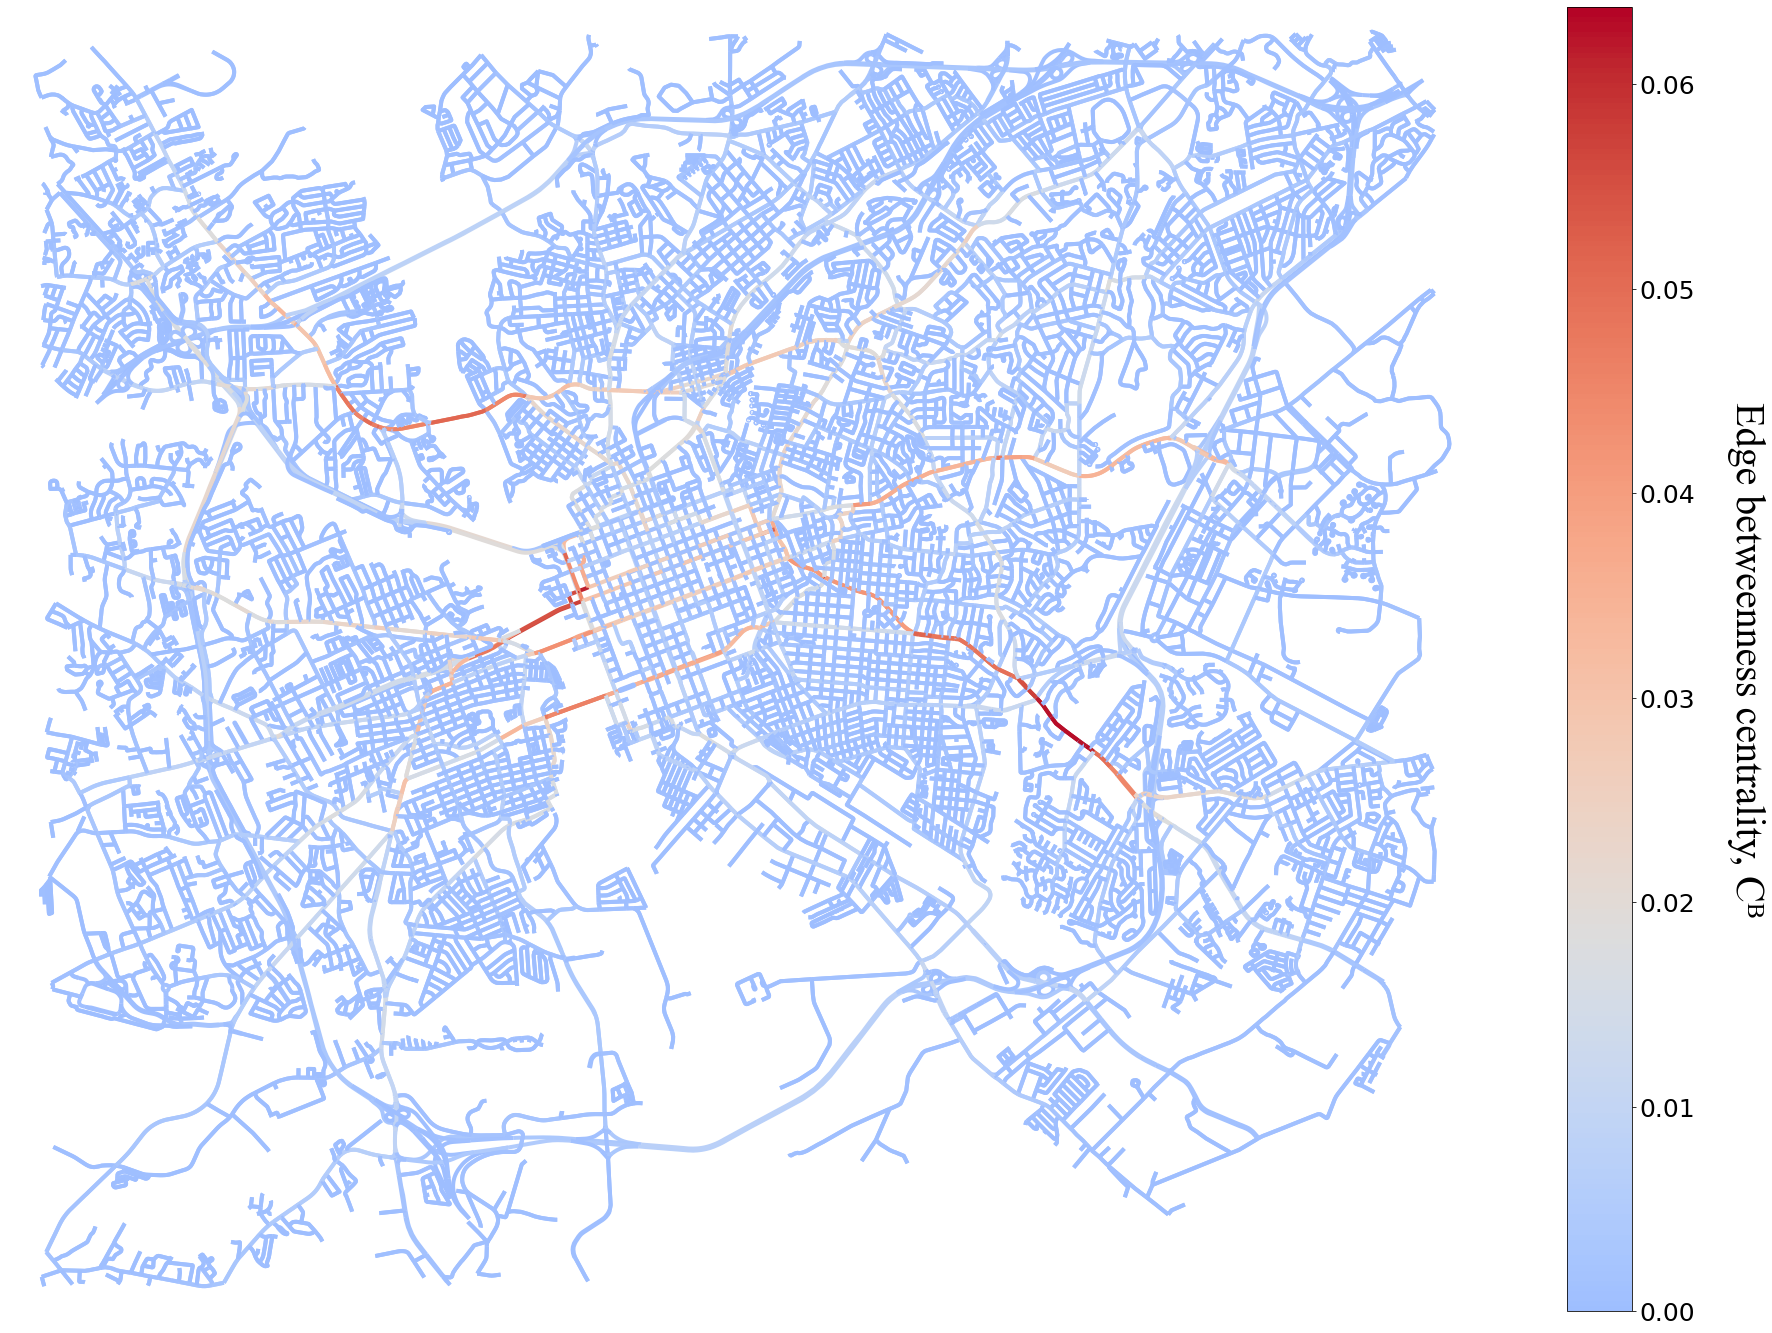

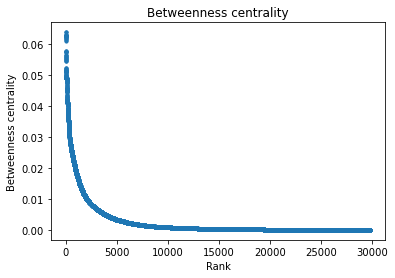

In [182]:
"""
# load data from a binary pickle file 
fname = cent_dir + 'bc_original.pkl'
rf = open(fname,"rb")
bc = pickle.load(rf)
rf.close()
"""
nx.set_edge_attributes(G, bc, "betweenness_centrality")

cmap_name = 'coolwarm'
#col_bin = 10
min_col = 0.30
max_col = 1

bet_edge_col = ox.plot.get_edge_colors_by_attr(G, "betweenness_centrality", cmap=cmap_name,
                                               start=min_col, stop=max_col, na_color='none')
bet_fig, bet_ax = ox.plot_graph(G, figsize=(40,24), node_color='b', node_size=0,
                                edge_linewidth=4, edge_color=bet_edge_col, show=False, close=False, bgcolor='w')


# Add a legend
cmap = plt.cm.get_cmap(cmap_name)
cmap = colors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=min_col, b=max_col),
         cmap(np.linspace(min_col, max_col, cmap.N)))
norm = plt.Normalize(vmin=min(bc.values()), vmax=max(bc.values()))
#bounds = np.linspace(min(bc.values()), max(bc.values()), col_bin+1)
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cb = bet_fig.colorbar(sm, fraction=0.05, pad=0.04, orientation='vertical')
#cb.ax.yaxis.set_ticks_position('left')
#cb.ax.yaxis.set_label_position('right')
cb.set_label('Edge betweenness centrality, Cᴮ', fontsize = 40, fontname='Times New Roman', rotation=270, labelpad=70)
cb.ax.tick_params(labelsize=25)

#bet_fig.suptitle(t='Betweenneess centrality in simplified network', y=0.93, size=40)
plt.show()
plt.close('all')

bc_vals = sorted(bc.values(), reverse=True)
x = [i for i in range(0, len(bc_vals))]

plt.scatter(x, bc_vals, s=10)
plt.title('Betweenness centrality')
plt.xlabel('Rank')
plt.ylabel('Betweenness centrality')

plt.show()
plt.close('all')

In [183]:
# create a binary pickle file 
f = open(cent_dir + "bc_original.pkl","wb")
pickle.dump(bc,f)

# close file
f.close()

In [68]:
# Get betweenness centrality of each edge
G2 = nx.DiGraph(G_wo_res)
bet_cent=nx.edge_betweenness_centrality(G2, weight='length')

# Add betweenness centrality to edge attribute
formatted_bet_cent = {}
for (u, v), value in bet_cent.items():
    formatted_bet_cent[(u, v, 0)] = value

# Fill missing values for multi-edges
for (u,v,k) in G_wo_res.edges:    
    if not (u,v,k) in formatted_bet_cent:
        formatted_bet_cent[(u,v,k)] = formatted_bet_cent[(u,v,0)]

nx.set_edge_attributes(G_wo_res, formatted_bet_cent, "betweenness_centrality")
bc = nx.get_edge_attributes(G_wo_res, 'betweenness_centrality')

# create a binary pickle file 
f = open(cent_dir + "bc_res_omitted.pkl","wb")
pickle.dump(bc,f)

# close file
f.close()

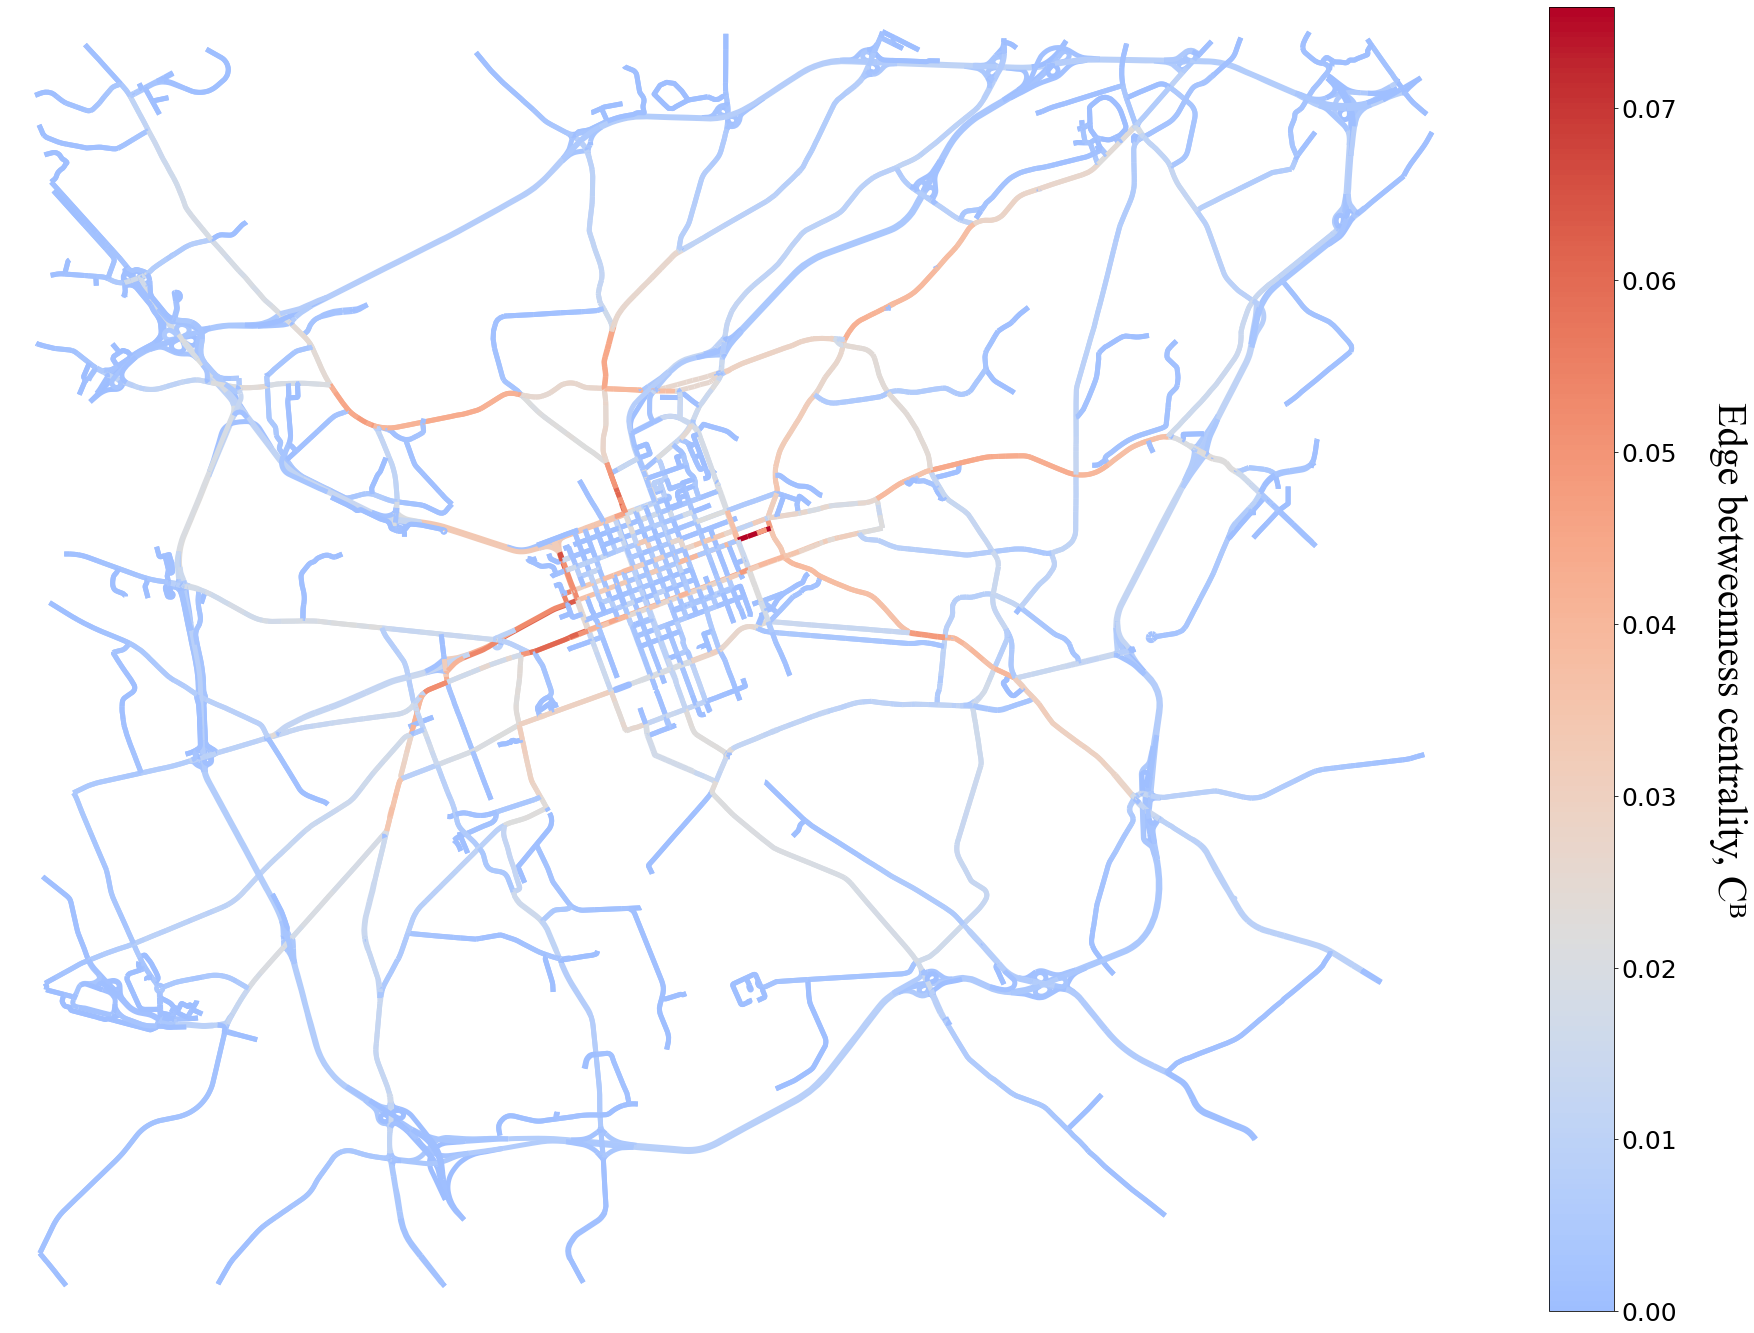

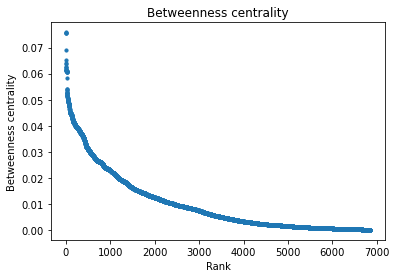

In [179]:
# load data from a binary pickle file 
fname = cent_dir + 'bc_res_omitted.pkl'
rf = open(fname,"rb")
bc = pickle.load(rf)
rf.close()

nx.set_edge_attributes(G_wo_res, bc, "betweenness_centrality")

cmap_name = 'coolwarm'
#col_bin = 10
min_col = 0.3
max_col = 1

bet_edge_col = ox.plot.get_edge_colors_by_attr(G_wo_res, "betweenness_centrality", cmap=cmap_name,
                                               start=min_col, stop=max_col, na_color='none')
bet_fig, bet_ax = ox.plot_graph(G_wo_res, figsize=(40,24), node_color='b', node_size=0,
                                edge_linewidth=5, edge_color=bet_edge_col, show=False, close=False, bgcolor='w',)
                                       #centrality_indice = "betweenness_centrality")


# Add a legend
cmap = plt.cm.get_cmap(cmap_name)
cmap = colors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=min_col, b=max_col),
         cmap(np.linspace(min_col, max_col, cmap.N)))
norm = plt.Normalize(vmin=min(bc.values()), vmax=max(bc.values()))
#bounds = np.linspace(min(bc.values()), max(bc.values()), col_bin+1)
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cb = bet_fig.colorbar(sm, fraction=0.05, pad=0.04, orientation='vertical')
#cb.ax.yaxis.set_ticks_position('left')
#cb.ax.yaxis.set_label_position('right')
cb.set_label('Edge betweenness centrality, Cᴮ', fontsize = 40, fontname='Times New Roman', rotation=270, labelpad=70)
cb.ax.tick_params(labelsize=25)

#bet_fig.suptitle(t='Betweenneess centrality in simplified network', y=0.93, size=40)
plt.show()
plt.close('all')

bc_vals = sorted(bc.values(), reverse=True)
x = [i for i in range(0, len(bc_vals))]

plt.scatter(x, bc_vals, s=10)
plt.title('Betweenness centrality')
plt.xlabel('Rank')
plt.ylabel('Betweenness centrality')

plt.show()
plt.close('all')

In [13]:
# create a binary pickle file 
f = open(cent_dir + "bc_res_omitted.pkl","wb")
pickle.dump(bc,f)

# close file
f.close()

In [184]:
# load data from binary pickle files
fname = cent_dir + 'bc_original.pkl'
rf = open(fname,"rb")
bc_org = pickle.load(rf)
rf.close()

fname = cent_dir + 'bc_simplified.pkl'
rf = open(fname,"rb")
bc_simple = pickle.load(rf)
rf.close()

"""
fname = cent_dir + 'bc_simplified_with_aggr_num.pkl'
rf = open(fname,"rb")
bc_simple_aggr = pickle.load(rf)
rf.close()
"""

def get_bc_for_simple_graph(org_bc_dic, simple_G, edge):
    u,v,k = edge
    edge_data = simple_G.get_edge_data(u,v,k)
    edge_betweenness_centrality = 0
    
    if 'consolidated_edges' in edge_data:
        """ # average value for consolidated edges
        for edge_segment in edge_data['consolidated_edges']:
            edge_betweenness_centrality += org_bc_dic[edge_segment]
        edge_betweenness_centrality = edge_betweenness_centrality / len(edge_data['consolidated_edges'])
        """
        # maximum value for consolidated edges
        consolidated_edge_vals = []
        for edge_segment in edge_data['consolidated_edges']:
            consolidated_edge_vals.append(org_bc_dic[edge_segment])
        edge_betweenness_centrality = max(consolidated_edge_vals)
    else:
        edge_betweenness_centrality = org_bc_dic[edge]
    
    return edge_betweenness_centrality

bc_data = {edge: [] for edge in G1.edges(keys=True)}

for edge in bc_data:
    bc_data[edge].append(get_bc_for_simple_graph(bc_org, G1, edge))
    bc_data[edge].append(bc_simple[edge])
    #bc_data[edge].append(bc_simple_aggr[edge])

bc_df = pd.DataFrame.from_dict(bc_data, orient='index', columns=['org', 'simple'])
display(bc_df)

org    simple
(88737495, 402525830, 0)     0.002347  0.004163
(113389145, 740587915, 0)    0.002776  0.002608
(113389145, 113399355, 0)    0.000790  0.001176
(113390024, 113693886, 0)    0.017873  0.011193
(113390024, 113690009, 0)    0.000028  0.000039
...                               ...       ...
(9387044811, 113980803, 0)   0.001842  0.002292
(9387044811, 113980799, 0)   0.003028  0.003605
(9387044812, 113980799, 0)   0.002771  0.002419
(9387044812, 9387063917, 0)  0.010277  0.010125
(9387063917, 9387044796, 0)  0.011908  0.011829

[15275 rows x 2 columns]

In [185]:
bc_df.corr(method='pearson')

org    simple
org     1.000000  0.951519
simple  0.951519  1.000000

In [186]:
bc_df.corr(method='spearman')

org    simple
org     1.000000  0.882929
simple  0.882929  1.000000

In [187]:
# Compare org network and network omitted all the residential roads
fname = cent_dir + 'bc_res_omitted.pkl'
rf = open(fname,"rb")
bc_res_omitted = pickle.load(rf)
rf.close()

bc_data = {edge: [] for edge in G_wo_res.edges(keys=True)}

for edge in bc_data:
    bc_data[edge].append(bc_org[edge])
    bc_data[edge].append(bc_res_omitted[edge])

bc_df = pd.DataFrame.from_dict(bc_data, orient='index', columns=['org', 'res_omitted'])
display(bc_df)

org  res_omitted
(88737495, 402525830, 0)     0.002347     0.006205
(113386577, 6881258523, 0)   0.009803     0.013105
(113386577, 113618048, 0)    0.010078     0.013872
(113389145, 740587915, 0)    0.002776     0.003791
(113389145, 113399355, 0)    0.000790     0.002701
...                               ...          ...
(9387044811, 113980803, 0)   0.001842     0.006327
(9387044811, 113980799, 0)   0.003028     0.008552
(9387044812, 113980799, 0)   0.002771     0.007307
(9387044812, 9387063917, 0)  0.010277     0.015793
(9387063917, 9387044796, 0)  0.011908     0.019069

[6851 rows x 2 columns]

In [188]:
bc_df.corr(method='pearson')

org  res_omitted
org          1.000000     0.804952
res_omitted  0.804952     1.000000

In [189]:
bc_df.corr(method='spearman')

org  res_omitted
org          1.000000     0.834331
res_omitted  0.834331     1.000000